## OBJECTIVE :

### Build classification model for classifying text into threat and non-threat categories.

In [1]:
import warnings
warnings.simplefilter("ignore")

In [4]:
import os
import sys
import ipdb
import numpy as np
import pandas as pd
import tensorflow as tf

print("Numpy Version : ", np.__version__)
print("Pandas Version : ", pd.__version__)

np.random.seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

print("Matplotlib Version : ", mpl.__version__)

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

Numpy Version :  1.18.2
Pandas Version :  1.0.3
Matplotlib Version :  3.2.1
Version:  2.1.0
Eager mode:  True
GPU is available


In [5]:
from joblib import load
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D, LSTM, GlobalMaxPool1D, Bidirectional
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, AlphaDropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import SGD, Nadam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score

In [6]:
sys.path.insert(0, os.path.abspath(os.path.join("..")))

In [7]:
import utils.text_processing as tp
from config import GLOVE_PATH, MAX_VOCAB_SIZE, MAX_SEQUENCE_LENGTH, EMBEDDING_DIM, VALIDATION_SPLIT, BATCH_SIZE, EPOCHS

In [8]:
DATA_DIR = "../data/"
OBJECT_DIR = "../objects/"
LOG_DIR = "../logs/"

In [9]:
TRAIN_DIR = os.path.join(DATA_DIR, "training_data/word_2_index/")

In [13]:
CLASSES = ["threat"]

In [11]:
train_data = pd.read_csv(os.path.join(TRAIN_DIR, "vectors_complex.csv"), encoding="utf-8")

In [12]:
train_data.head()

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,threat
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5,1
1,0,0,0,0,0,0,0,0,0,0,...,2009,164,18,2010,46,174,26,111,751,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,231,1,2011,1
3,0,0,0,0,0,0,0,0,0,0,...,58,28,443,619,2013,38,32,111,40,1
4,0,0,0,0,0,0,0,0,0,0,...,45,76,67,752,63,2017,299,28,2018,1


In [24]:
X = train_data[[str(i) for i in np.arange(0, 100, 1)]].values
y = train_data[CLASSES].values

In [25]:
X.shape, y.shape

((800, 100), (800, 1))

In [26]:
X

array([[   0,    0,    0, ...,    0,    0,    5],
       [   0,    0,    0, ...,   26,  111,  751],
       [   0,    0,    0, ...,  231,    1, 2011],
       ...,
       [   0,    0,    0, ...,    4,  408,  236],
       [   0,    0,    0, ...,   11,   45, 1508],
       [   0,    0,    0, ...,    0,    0,    5]])

In [27]:
y

array([[1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
    

In [28]:
tokenizer = load(os.path.join(OBJECT_DIR, "tokenizer.joblib"))

In [29]:
word_ind_dict = tokenizer.word_index

In [30]:
GLOVE_PATH = "/home/praveen/pk_works/nlp/glove"
GLOVE_PATH = os.path.join(GLOVE_PATH, "glove.6B.{}d.txt".format(EMBEDDING_DIM))
GLOVE_PATH

'/home/praveen/pk_works/nlp/glove/glove.6B.100d.txt'

In [31]:
num_words = min(MAX_VOCAB_SIZE, len(word_ind_dict) + 1)

In [32]:
num_words

4560

In [33]:
len(word_ind_dict)

4559

In [34]:
embed_matrix = tp.get_embedding_matrix(GLOVE_PATH, word_ind_dict, num_words, EMBEDDING_DIM, MAX_VOCAB_SIZE)

In [37]:
embed_matrix.shape

(4560, 100)

In [38]:
embed_layer = tp.get_embedding_layer(num_words, EMBEDDING_DIM, embed_matrix, MAX_SEQUENCE_LENGTH)

In [39]:
embed_layer.get_config()

{'name': 'embedding',
 'trainable': False,
 'batch_input_shape': (None, 100),
 'dtype': 'float32',
 'input_dim': 4560,
 'output_dim': 100,
 'embeddings_initializer': {'class_name': 'RandomUniform',
  'config': {'minval': -0.05, 'maxval': 0.05, 'seed': None}},
 'embeddings_regularizer': None,
 'activity_regularizer': None,
 'embeddings_constraint': None,
 'mask_zero': False,
 'input_length': 100}

In [40]:
num_words, EMBEDDING_DIM, MAX_SEQUENCE_LENGTH

(4560, 100, 100)

In [56]:
def create_cnn_model():
    # train a 1D convnet with global maxpooling
    input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
    x = embed_layer(input_)
    x = Conv1D(128, 3, activation='relu', kernel_initializer="he_normal")(x)
    x = Dropout(0.40)(x)
    x = MaxPooling1D(3)(x)
#     x = Conv1D(128, 3, activation='selu', kernel_initializer="lecun_normal")(x)
#     x = AlphaDropout(0.45)(x)
#     x = MaxPooling1D(3)(x)
#     x = Conv1D(128, 3, activation='selu', kernel_initializer="lecun_normal")(x)
#     x = AlphaDropout(0.45)(x)
    x = GlobalMaxPooling1D()(x)
    x = Dense(128, activation='relu', kernel_initializer="he_normal")(x)
    x = Dropout(0.45)(x)
    output = Dense(len(CLASSES), activation='sigmoid')(x)
    model = Model(input_, output)
    return model

In [65]:
# wavenet architecture
def create_cnn_dilation_model():
    model = Sequential()
    model.add(Input(shape=(MAX_SEQUENCE_LENGTH,)))
    model.add(embed_layer)
    for rate in (1, 2, 4, 8) * 2:
        model.add(Conv1D(filters=20, kernel_size=2, padding="causal", 
                         activation="relu", kernel_initializer="he_normal", dilation_rate=rate))
        model.add(Dropout(0.35))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(128, activation='relu', kernel_initializer="he_normal"))
    model.add(Dropout(0.45))
    model.add(Dense(len(CLASSES), activation='sigmoid'))
    return model

In [90]:
def create_lstm_model():
    input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
    x = embed_layer(input_)
    x = LSTM(15, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)(x)
    x = GlobalMaxPool1D()(x)
    output = Dense(len(CLASSES), activation="sigmoid")(x)
    model = Model(input_, output)
    return model

In [107]:
def create_bidirectional_model():
    input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
    x = embed_layer(input_)
    x = Bidirectional(LSTM(15, return_sequences=True, dropout=0.4, recurrent_dropout=0.4))(x)
    x = GlobalMaxPool1D()(x)
    output = Dense(len(CLASSES), activation="sigmoid")(x)
    model = Model(input_, output)
    return model

In [108]:
model = create_bidirectional_model()

In [109]:
model.get_config()

{'name': 'model_6',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 100),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_8'},
   'name': 'input_8',
   'inbound_nodes': []},
  {'class_name': 'Embedding',
   'config': {'name': 'embedding',
    'trainable': False,
    'batch_input_shape': (None, 100),
    'dtype': 'float32',
    'input_dim': 4560,
    'output_dim': 100,
    'embeddings_initializer': {'class_name': 'RandomUniform',
     'config': {'minval': -0.05, 'maxval': 0.05, 'seed': None}},
    'embeddings_regularizer': None,
    'activity_regularizer': None,
    'embeddings_constraint': None,
    'mask_zero': False,
    'input_length': 100},
   'name': 'embedding',
   'inbound_nodes': [[['input_8', 0, 0, {}]]]},
  {'class_name': 'Bidirectional',
   'config': {'name': 'bidirectional',
    'trainable': True,
    'dtype': 'float32',
    'layer': {'class_name': 'LSTM',
     'config': {'name': 'lstm_4',
      'traina

In [110]:
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 100)          456000    
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 30)           13920     
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 30)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 31        
Total params: 469,951
Trainable params: 13,951
Non-trainable params: 456,000
_________________________________________________________________


In [111]:
model.compile(
  loss='binary_crossentropy',
  optimizer=Nadam(lr=0.001, beta_1=0.9, beta_2=0.999),
  metrics=['accuracy']
)

In [112]:
history = model.fit(
    X,
    y,
    batch_size=BATCH_SIZE,
    epochs=200,
    validation_split=VALIDATION_SPLIT,
    callbacks=[EarlyStopping(patience=10)]
)

Train on 640 samples, validate on 160 samples
Epoch 1/200
640/640 [==============================] - 3s 5ms/sample - loss: 0.7136 - accuracy: 0.4891 - val_loss: 0.6860 - val_accuracy: 0.5562
Epoch 2/200
640/640 [==============================] - 1s 1ms/sample - loss: 0.6901 - accuracy: 0.5656 - val_loss: 0.6685 - val_accuracy: 0.6313
Epoch 3/200
640/640 [==============================] - 1s 1ms/sample - loss: 0.6658 - accuracy: 0.5969 - val_loss: 0.6489 - val_accuracy: 0.7063
Epoch 4/200
640/640 [==============================] - 1s 1ms/sample - loss: 0.6419 - accuracy: 0.7156 - val_loss: 0.6279 - val_accuracy: 0.7563
Epoch 5/200
640/640 [==============================] - 1s 1ms/sample - loss: 0.6134 - accuracy: 0.7484 - val_loss: 0.6040 - val_accuracy: 0.7750
Epoch 6/200
640/640 [==============================] - 1s 1ms/sample - loss: 0.5904 - accuracy: 0.7984 - val_loss: 0.5768 - val_accuracy: 0.8062
Epoch 7/200
640/640 [==============================] - 1s 1ms/sample - loss: 0.5566 

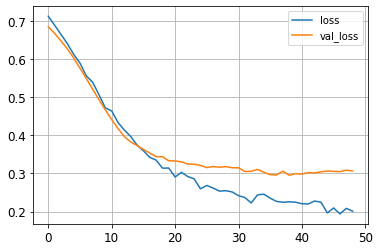

In [113]:
# plot some data
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.grid()
plt.show()

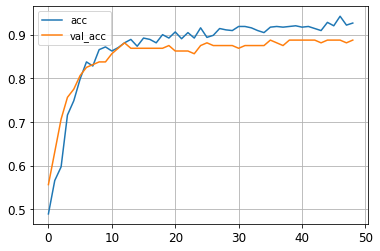

In [114]:
# accuracies
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.grid()
plt.show()

In [115]:
# For threat class only
p = model.predict(X)
p = np.where(p > 0.5, 1, 0)
print("Shape of predicted values : ", p.shape)
print("Shape of target values : ", y.shape)
tn, fp, fn, tp = confusion_matrix(y, p).ravel()
print("True neg : ", tn)
print("False pos : ", fp)
print("False neg : ", fn)
print("True pos : ", tp)
print()
print(classification_report(y, p))
print()
print("ROC : {}".format(roc_auc_score(y, p)))
print()
print("Precision : {}".format(precision_score(y, p)))
print()
print("Accuracy : {}".format(accuracy_score(y, p)))
print()
print("Recall : {}".format(recall_score(y, p)))
print()
print("F1 : {}".format(f1_score(y, p)))
print()

Shape of predicted values :  (800, 1)
Shape of target values :  (800, 1)
True neg :  363
False pos :  37
False neg :  17
True pos :  383

              precision    recall  f1-score   support

           0       0.96      0.91      0.93       400
           1       0.91      0.96      0.93       400

    accuracy                           0.93       800
   macro avg       0.93      0.93      0.93       800
weighted avg       0.93      0.93      0.93       800


ROC : 0.9325

Precision : 0.9119047619047619

Accuracy : 0.9325

Recall : 0.9575

F1 : 0.9341463414634146

